Очищенный аудиофайл сохранён: cleaned_audio.wav


C:\Users\hello\AppData\Local\Temp\ipykernel_13768\502586007.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, clean_audio = wavfile.read('clean.wav')
C:\Users\hello\AppData\Local\Temp\ipykernel_13768\502586007.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, noisy_audio = wavfile.read('cleanplusstreet.wav')


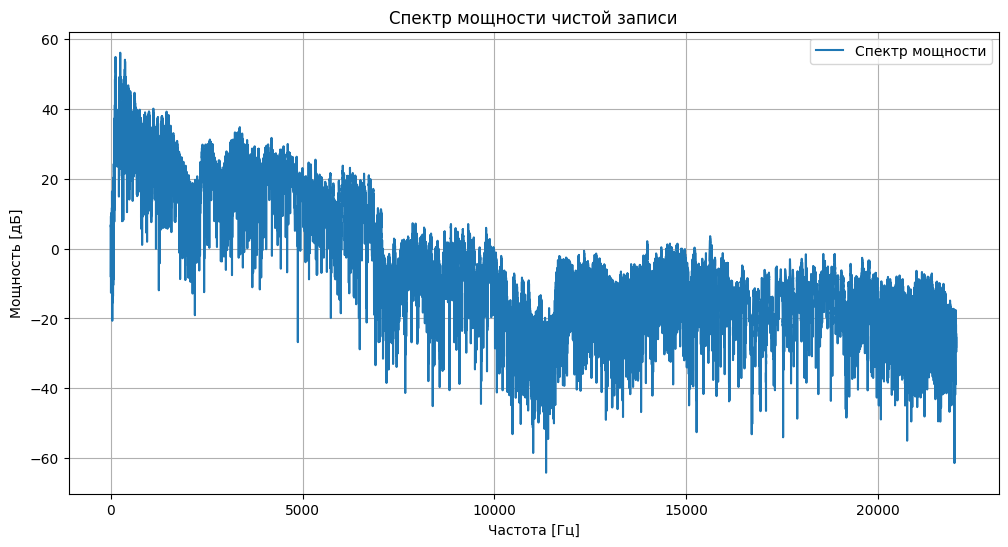

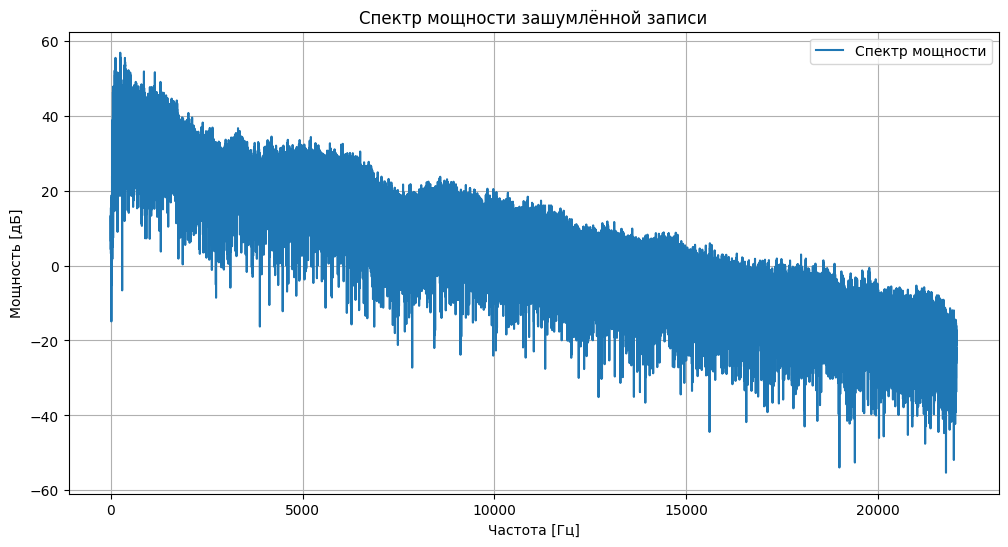

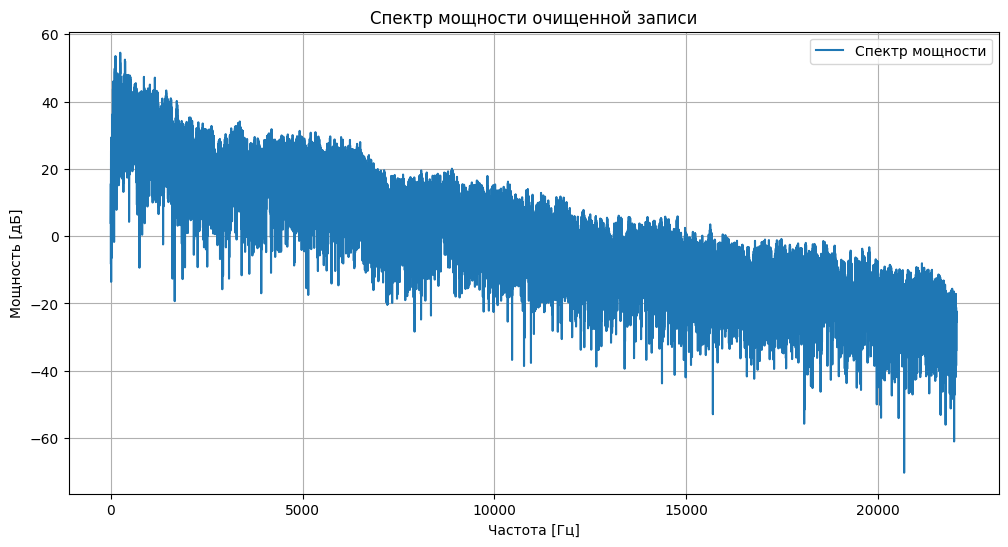

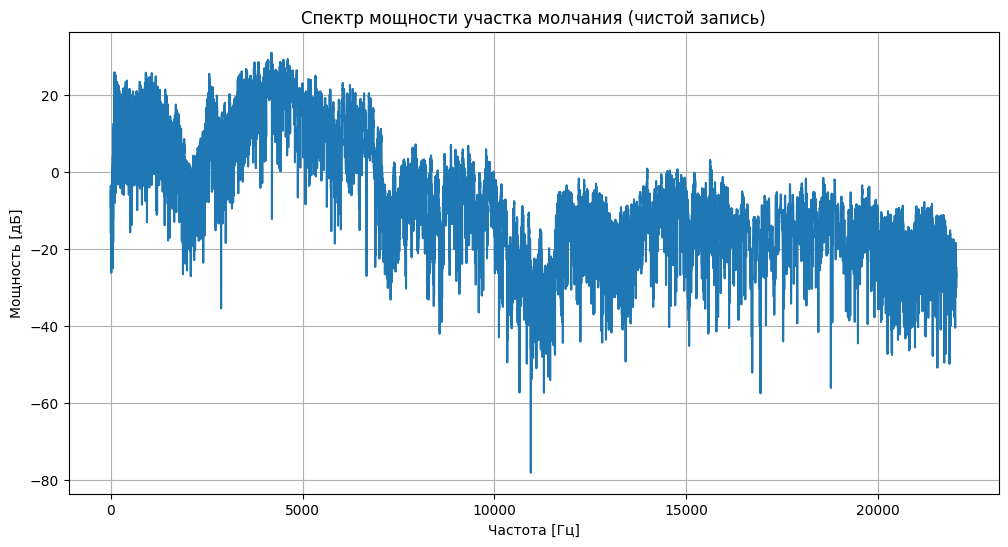

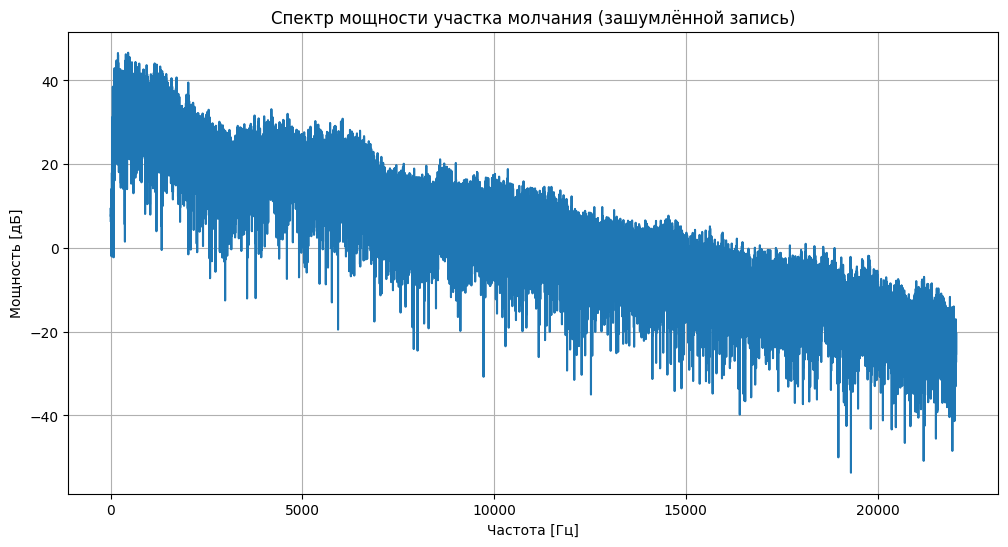


Анализ шумов в чистой записи:

Оценка амплитуд шумов в частотных диапазонах:
125 Гц диапазон (90-180 Гц): средняя мощность = 12.38 дБ
250 Гц диапазон (180-355 Гц): средняя мощность = 12.10 дБ
500 Гц диапазон (355-710 Гц): средняя мощность = 12.01 дБ
1000 Гц диапазон (710-1400 Гц): средняя мощность = 12.60 дБ
2000 Гц диапазон (1400-2800 Гц): средняя мощность = 3.66 дБ
4000 Гц диапазон (2800-5600 Гц): средняя мощность = 16.56 дБ
8000 Гц диапазон (5600-11200 Гц): средняя мощность = -5.71 дБ

Анализ шумов в зашумлённой записи:

Оценка амплитуд шумов в частотных диапазонах:
125 Гц диапазон (90-180 Гц): средняя мощность = 33.71 дБ
250 Гц диапазон (180-355 Гц): средняя мощность = 33.02 дБ
500 Гц диапазон (355-710 Гц): средняя мощность = 33.60 дБ
1000 Гц диапазон (710-1400 Гц): средняя мощность = 32.44 дБ
2000 Гц диапазон (1400-2800 Гц): средняя мощность = 25.36 дБ
4000 Гц диапазон (2800-5600 Гц): средняя мощность = 20.06 дБ
8000 Гц диапазон (5600-11200 Гц): средняя мощность = 10.16 дБ

Корре

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import get_window

# Загрузка аудиофайлов
sample_rate, clean_audio = wavfile.read('clean.wav')
sample_rate, noisy_audio = wavfile.read('cleanplusstreet.wav')

# Преобразование в моно при необходимости
if len(clean_audio.shape) > 1:
    clean_audio = clean_audio[:, 0]
if len(noisy_audio.shape) > 1:
    noisy_audio = noisy_audio[:, 0]

# Обрезка до одной длины
min_length = min(len(clean_audio), len(noisy_audio))
clean_audio = clean_audio[:min_length]
noisy_audio = noisy_audio[:min_length]

# Нормализация
clean_audio = clean_audio / np.max(np.abs(clean_audio))
noisy_audio = noisy_audio / np.max(np.abs(noisy_audio))

# Параметры окон и фреймов
frame_size = int(0.04 * sample_rate)
hop_length = frame_size // 2
window = get_window('hamming', frame_size)

# Спектральное вычитание
def spectral_subtraction(noisy_signal, noise_profile, window, frame_size, hop_length):
    windowed_noise = noise_profile * window
    noise_spectrum = np.fft.rfft(windowed_noise)
    noise_power = np.abs(noise_spectrum) ** 2

    output_signal = np.zeros_like(noisy_signal)
    num_frames = int(np.floor((len(noisy_signal) - frame_size) / hop_length))

    for i in range(num_frames):
        frame = noisy_signal[i * hop_length:i * hop_length + frame_size]
        windowed_frame = frame * window
        frame_spectrum = np.fft.rfft(windowed_frame)
        frame_power = np.abs(frame_spectrum) ** 2

        cleaned_power = frame_power - noise_power
        cleaned_power = np.maximum(cleaned_power, 0)
        cleaned_amplitude = np.sqrt(cleaned_power) * np.exp(1j * np.angle(frame_spectrum))

        cleaned_frame = np.fft.irfft(cleaned_amplitude)

        output_signal[i * hop_length:i * hop_length + frame_size] += window * cleaned_frame

    return output_signal

# Профиль шума из начала записи
noise_profile = noisy_audio[:frame_size]
cleaned_audio = spectral_subtraction(noisy_audio, noise_profile, window, frame_size, hop_length)
cleaned_audio = cleaned_audio / np.max(np.abs(cleaned_audio))

# Сохранение очищенного аудио
output_filename = 'cleaned_audio.wav'
wavfile.write(output_filename, sample_rate, cleaned_audio.astype(np.float32))
print(f"Очищенный аудиофайл сохранён: {output_filename}")

# Спектр мощности
def compute_power_spectrum(audio, sample_rate):
    n = len(audio)
    audio_fft = np.fft.rfft(audio)
    power_spectrum = np.abs(audio_fft) ** 2
    frequencies = np.fft.rfftfreq(n, d=1/sample_rate)
    return frequencies, power_spectrum

frequencies_clean, power_spectrum_clean = compute_power_spectrum(clean_audio, sample_rate)
frequencies_noisy, power_spectrum_noisy = compute_power_spectrum(noisy_audio, sample_rate)
frequencies_cleaned, power_spectrum_cleaned = compute_power_spectrum(cleaned_audio, sample_rate)

power_spectrum_clean_db = 10 * np.log10(power_spectrum_clean + 1e-12)
power_spectrum_noisy_db = 10 * np.log10(power_spectrum_noisy + 1e-12)
power_spectrum_cleaned_db = 10 * np.log10(power_spectrum_cleaned + 1e-12)

# Функция для построения спектра мощности без выделения диапазонов
def plot_spectrum(frequencies, power_spectrum_db, title):
    plt.figure(figsize=(12, 6))
    plt.plot(frequencies, power_spectrum_db, label='Спектр мощности')
    plt.title(title)
    plt.xlabel('Частота [Гц]')
    plt.ylabel('Мощность [дБ]')
    plt.grid()
    plt.legend()
    plt.show()

plot_spectrum(frequencies_clean, power_spectrum_clean_db, 'Спектр мощности чистой записи')
plot_spectrum(frequencies_noisy, power_spectrum_noisy_db, 'Спектр мощности зашумлённой записи')
plot_spectrum(frequencies_cleaned, power_spectrum_cleaned_db, 'Спектр мощности очищенной записи')

# Поиск участков молчания
def find_silent_segments(audio, sample_rate, threshold=0.01):
    window_size = int(sample_rate * 0.05)
    energy = np.convolve(audio**2, np.ones(window_size)/window_size, mode='same')
    silent = energy < threshold
    silent_segments = []
    start = 0
    for i in range(1, len(silent)):
        if silent[i] and not silent[i-1]:
            start = i
        elif not silent[i] and silent[i-1]:
            silent_segments.append((start, i))
    return silent_segments

clean_silent = find_silent_segments(clean_audio, sample_rate)
noisy_silent = find_silent_segments(noisy_audio, sample_rate)

def analyze_silent_segments(audio, silent_segments, sample_rate, name):
    if not silent_segments:
        print(f"Не найдено участков молчания в {name} записи")
        return None, None
    start, end = silent_segments[0]
    silent_audio = audio[start:end]
    freqs, power = compute_power_spectrum(silent_audio, sample_rate)
    power_db = 10 * np.log10(power + np.finfo(float).eps)
    plt.figure(figsize=(12, 6))
    plt.plot(freqs, power_db)
    plt.title(f'Спектр мощности участка молчания ({name} запись)')
    plt.xlabel('Частота [Гц]')
    plt.ylabel('Мощность [дБ]')
    plt.grid()
    plt.show()
    return freqs, power_db

clean_silent_freqs, clean_silent_power_db = analyze_silent_segments(clean_audio, clean_silent, sample_rate, "чистой")
noisy_silent_freqs, noisy_silent_power_db = analyze_silent_segments(noisy_audio, noisy_silent, sample_rate, "зашумлённой")

def analyze_noise_bands(freqs, power_db, sample_rate):
    bands = [
        (90, 180, '125 Гц'), (180, 355, '250 Гц'), (355, 710, '500 Гц'),
        (710, 1400, '1000 Гц'), (1400, 2800, '2000 Гц'),
        (2800, 5600, '4000 Гц'), (5600, 11200, '8000 Гц')
    ]
    print("\nОценка амплитуд шумов в частотных диапазонах:")
    for low, high, label in bands:
        mask = (freqs >= low) & (freqs <= high)
        if any(mask):
            avg_power_db = np.mean(power_db[mask])
            print(f"{label} диапазон ({low}-{high} Гц): средняя мощность = {avg_power_db:.2f} дБ")
        else:
            print(f"{label} диапазон ({low}-{high} Гц): нет данных")

if clean_silent_power_db is not None:
    print("\nАнализ шумов в чистой записи:")
    analyze_noise_bands(clean_silent_freqs, clean_silent_power_db, sample_rate)

if noisy_silent_power_db is not None:
    print("\nАнализ шумов в зашумлённой записи:")
    analyze_noise_bands(noisy_silent_freqs, noisy_silent_power_db, sample_rate)

# Корреляции
correlation_noisy_clean = np.corrcoef(clean_audio, noisy_audio)[0, 1]
correlation_cleaned_clean = np.corrcoef(clean_audio, cleaned_audio)[0, 1]
correlation_noisy_cleaned = np.corrcoef(noisy_audio, cleaned_audio)[0, 1]
print(f"\nКорреляция между чистой и зашумлённой записью: {correlation_noisy_clean:.4f}")
print(f"Корреляция между чистой и очищенной записью: {correlation_cleaned_clean:.4f}")
print(f"Корреляция между зашумлённой и очищенной записью: {correlation_noisy_cleaned:.4f}")

# Метод Покровского — расчёт индекса артикуляции
def calculate_articulation_index(audio, sample_rate):
    bands = [
        (100, 420), (420, 570), (570, 710), (710, 865), (865, 1030),
        (1030, 1220), (1220, 1410), (1410, 1600), (1600, 1780), (1780, 1960),
        (1960, 2140), (2140, 2320), (2320, 2550), (2550, 2900), (2900, 3300),
        (3300, 3660), (3660, 4050), (4050, 5010), (5010, 7250), (7250, 10000)
    ]
    frequencies, power_spectrum = compute_power_spectrum(audio, sample_rate)
    power_spectrum_db = 10 * np.log10(power_spectrum + np.finfo(float).eps)
    AI = 0
    for low, high in bands:
        mask = (frequencies >= low) & (frequencies <= high)
        band_power_db = power_spectrum_db[mask]
        if len(band_power_db) > 0:
            noise_level_db = np.mean(band_power_db)
            peak_level_db = np.max(band_power_db)
            delta_L = peak_level_db - noise_level_db
            normalized_delta_L = np.clip((delta_L + 30) / 60, 0, 1)
            AI += normalized_delta_L
    AI /= len(bands)
    return AI

AI_clean = calculate_articulation_index(clean_audio, sample_rate)
AI_noisy = calculate_articulation_index(noisy_audio, sample_rate)
AI_cleaned = calculate_articulation_index(cleaned_audio, sample_rate)
print(f"\nИндекс артикуляции (AI) для чистой записи: {AI_clean:.4f}")
print(f"Индекс артикуляции (AI) для зашумлённой записи: {AI_noisy:.4f}")
print(f"Индекс артикуляции (AI) для очищенной записи: {AI_cleaned:.4f}")
